In [1]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/Colab Notebooks/ECE253/')
import os
path="/content/drive/My Drive/Colab Notebooks/ECE253/"
os.chdir(path)
os.listdir(path)

!pip install -q scikit-image tqdm

import os
import numpy as np
from glob import glob
from tqdm import tqdm

from skimage import io, img_as_float, img_as_ubyte
from skimage.restoration import richardson_lucy
from skimage.color import rgb2gray
from skimage.filters import laplace
from skimage.transform import resize
from scipy.ndimage import rotate
!ls

Mounted at /content/drive
 DeblurResult				        MPRNet.ipynb
'ECE 253 Project Final Presentation.gslides'    MPRNet-main
'ECE 253 Project Update Presentation.gslides'   NLM.ipynb
 FFDNet-main				        RichardsonLucy.ipynb


In [3]:
import os
from glob import glob

import numpy as np
from tqdm import tqdm

from skimage import io
from skimage.util import img_as_float, img_as_ubyte
from skimage.transform import resize
from scipy.ndimage import rotate
from skimage.color import rgb2gray
from scipy.ndimage import laplace
from skimage.restoration import richardson_lucy
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

# ==========================
# Paths
# ==========================
# Example (GoPro):
# TEST_INPUT_DIR = "./MPRNet-main/Deblurring/Datasets/GoPro/test/input"
# TEST_GT_DIR    = "./MPRNet-main/Deblurring/Datasets/GoPro/test/target"
# OUTPUT_DIR     = "./DeblurResult/GoPro_RL/output"

# RealBlur (common structure, adjust GT dir if needed):
TEST_INPUT_DIR = "./MPRNet-main/Deblurring/Datasets/RealBlur/test/input"
TEST_GT_DIR    = "./MPRNet-main/Deblurring/Datasets/RealBlur/test/target"  # <-- change if your folder name is different
OUTPUT_DIR     = "./DeblurResult/RealBlur_RL/output"

os.makedirs(OUTPUT_DIR, exist_ok=True)
print("Input dir exists:", os.path.exists(TEST_INPUT_DIR))
print("GT dir exists:", os.path.exists(TEST_GT_DIR))
print("Output dir:", OUTPUT_DIR)

# ==========================
# Optional: LPIPS (if available)
# ==========================
LPIPS_AVAILABLE = False
lpips_model = None
try:
    import torch
    import lpips

    device = "cuda" if torch.cuda.is_available() else "cpu"
    lpips_model = lpips.LPIPS(net="alex").to(device)
    lpips_model.eval()
    LPIPS_AVAILABLE = True
    print("LPIPS is available. Device:", device)
except Exception as e:
    print("LPIPS not available (skipping LPIPS). Reason:", str(e))

def compute_lpips(img1_rgb_float01, img2_rgb_float01):
    """
    LPIPS expects tensors in [-1, 1], shape [1, 3, H, W].
    img1/img2: float32/float64, [0,1], HxWx3
    """
    if not LPIPS_AVAILABLE:
        return None

    x = torch.from_numpy(img1_rgb_float01).permute(2, 0, 1).unsqueeze(0).float()
    y = torch.from_numpy(img2_rgb_float01).permute(2, 0, 1).unsqueeze(0).float()
    x = x * 2.0 - 1.0
    y = y * 2.0 - 1.0
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
        d = lpips_model(x, y).item()
    return float(d)

# ==========================
# PSF generator (motion blur kernel)
# ==========================
def motion_blur_psf(length=15, angle=0, size=31):
    """
    Create a simple linear motion blur PSF.
    length: blur length in pixels
    angle:  direction in degrees (counter-clockwise)
    size:   PSF size (size x size), should be odd
    """
    psf = np.zeros((size, size), dtype=np.float32)
    center = size // 2
    psf[center, center - length // 2 : center + length // 2 + 1] = 1.0
    psf = rotate(psf, angle, reshape=False)
    psf /= (psf.sum() + 1e-8)
    return psf

# ==========================
# RL deconvolution (RGB)
# ==========================
def rl_deconvolution_rgb(img, psf, num_iter=20):
    """
    Richardson-Lucy deconvolution per RGB channel.
    img: HxWx3, float in [0,1]
    psf: Hk x Wk
    """
    out = np.zeros_like(img)
    for c in range(3):
        out[..., c] = richardson_lucy(img[..., c], psf, num_iter=num_iter, clip=False)
    return np.clip(out, 0.0, 1.0)

# ==========================
# Sharpness score (variance of Laplacian)
# ==========================
def sharpness_score(img):
    """
    No-reference sharpness proxy:
    - convert to grayscale
    - Laplacian
    - variance as sharpness score (higher is sharper)
    """
    gray = rgb2gray(img) if img.ndim == 3 else img
    lap = laplace(gray)
    return float(lap.var())

# ==========================
# Search best (length, angle)
# ==========================
def find_best_psf_for_image(
    img,
    length_list=(7, 9, 11),
    angle_list=(0, 10, 20, 30),
    base_iter=8,
    psf_size=31,
):
    """
    Search PSF parameters on a downscaled image for speed.
    Returns: best_psf, best_length, best_angle, best_score
    """
    H, W = img.shape[:2]
    scale = 0.5 if max(H, W) > 720 else 1.0
    img_small = resize(img, (int(H * scale), int(W * scale)), anti_aliasing=True) if scale < 1.0 else img

    best_score = -1.0
    best_psf = None
    best_length = None
    best_angle = None

    for L in length_list:
        for A in angle_list:
            psf = motion_blur_psf(length=L, angle=A, size=psf_size)
            rl_small = rl_deconvolution_rgb(img_small, psf, num_iter=base_iter)
            score = sharpness_score(rl_small)
            if score > best_score:
                best_score = score
                best_psf = psf
                best_length = L
                best_angle = A

    return best_psf, best_length, best_angle, best_score

# ==========================
# Helper: match GT by filename
# ==========================
def find_gt_path(input_path, gt_dir):
    """
    Try to find the corresponding GT image in gt_dir by the same basename,
    or by swapping common suffixes if needed.
    """
    base = os.path.basename(input_path)
    candidates = [
        os.path.join(gt_dir, base),
        os.path.join(gt_dir, base.replace("blur", "sharp")),
        os.path.join(gt_dir, base.replace("input", "target")),
        os.path.join(gt_dir, base.replace("input", "gt")),
    ]
    for p in candidates:
        if os.path.exists(p):
            return p

    # fallback: search by stem
    stem = os.path.splitext(base)[0]
    matches = glob(os.path.join(gt_dir, stem + ".*"))
    return matches[0] if len(matches) > 0 else None

# ==========================
# Collect images
# ==========================
img_files = sorted(
    glob(os.path.join(TEST_INPUT_DIR, "*.png"))
    + glob(os.path.join(TEST_INPUT_DIR, "*.jpg"))
    + glob(os.path.join(TEST_INPUT_DIR, "*.jpeg"))
)

print("Found", len(img_files), "images.")

N = 5  # number of images to process
img_files = img_files[:N]
print("Processing", len(img_files), "images.")

# ==========================
# Metrics accumulators
# ==========================
per_image_records = []
psnr_list = []
ssim_list = []
lpips_list = []

# ==========================
# Main loop
# ==========================
for img_path in tqdm(img_files):
    # Read input
    img = io.imread(img_path)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    img_float = img_as_float(img)

    # Find GT and read it (if exists)
    gt_path = find_gt_path(img_path, TEST_GT_DIR) if os.path.exists(TEST_GT_DIR) else None
    gt_float = None
    if gt_path is not None and os.path.exists(gt_path):
        gt = io.imread(gt_path)
        if gt.ndim == 2:
            gt = np.stack([gt, gt, gt], axis=-1)
        gt_float = img_as_float(gt)

        # Ensure same size
        if gt_float.shape[:2] != img_float.shape[:2]:
            gt_float = resize(gt_float, img_float.shape[:2], anti_aliasing=True)
    else:
        print(f"\nWarning: GT not found for {os.path.basename(img_path)}. Metrics will be skipped for this image.")

    # 1) Search best PSF parameters
    best_psf, best_L, best_A, best_score = find_best_psf_for_image(
        img_float,
        length_list=[5],     # tune as needed
        angle_list=[20],     # tune as needed
        base_iter=1,
        psf_size=31,
    )
    print(
        f"\nBest PSF for {os.path.basename(img_path)}: "
        f"L={best_L}, A={best_A}, sharpness={best_score:.4f}"
    )

    # 2) RL deconvolution
    rl_img = rl_deconvolution_rgb(img_float, best_psf, num_iter=20)

    # 3) Save result
    rl_uint8 = img_as_ubyte(rl_img)
    save_path = os.path.join(OUTPUT_DIR, os.path.basename(img_path))
    io.imsave(save_path, rl_uint8)

    # 4) Compute metrics if GT exists
    psnr_val, ssim_val, lpips_val = None, None, None
    if gt_float is not None:
        psnr_val = float(peak_signal_noise_ratio(gt_float, rl_img, data_range=1.0))
        ssim_val = float(structural_similarity(gt_float, rl_img, channel_axis=-1, data_range=1.0))
        lpips_val = compute_lpips(rl_img, gt_float) if LPIPS_AVAILABLE else None

        psnr_list.append(psnr_val)
        ssim_list.append(ssim_val)
        if lpips_val is not None:
            lpips_list.append(lpips_val)

    per_image_records.append(
        {
            "name": os.path.basename(img_path),
            "gt_found": gt_float is not None,
            "best_length": best_L,
            "best_angle": best_A,
            "sharpness_score": best_score,
            "psnr": psnr_val,
            "ssim": ssim_val,
            "lpips": lpips_val,
            "output_path": save_path,
        }
    )

# ==========================
# Summary
# ==========================
num_with_gt = sum(1 for r in per_image_records if r["gt_found"])
print("\n==========================")
print("Done! Results saved to:", OUTPUT_DIR)
print("Images processed:", len(per_image_records))
print("Images with GT:", num_with_gt)

if num_with_gt > 0:
    print("Average PSNR:", float(np.mean(psnr_list)) if len(psnr_list) > 0 else None)
    print("Average SSIM:", float(np.mean(ssim_list)) if len(ssim_list) > 0 else None)
    if LPIPS_AVAILABLE and len(lpips_list) > 0:
        print("Average LPIPS:", float(np.mean(lpips_list)))
    else:
        print("Average LPIPS: None (LPIPS not available or no valid scores)")

# ==========================
# Save metrics to CSV
# ==========================
import csv

csv_path = os.path.join(OUTPUT_DIR, "metrics.csv")
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=[
            "name",
            "gt_found",
            "best_length",
            "best_angle",
            "sharpness_score",
            "psnr",
            "ssim",
            "lpips",
            "output_path",
        ],
    )
    writer.writeheader()
    for r in per_image_records:
        writer.writerow(r)

print("Saved per-image metrics to:", csv_path)

Input dir exists: True
GT dir exists: True
Output dir: ./DeblurResult/RealBlur_RL/output
LPIPS not available (skipping LPIPS). Reason: No module named 'lpips'
Found 40 images.
Processing 5 images.


  0%|          | 0/5 [00:00<?, ?it/s]


Best PSF for scene006-10.png: L=5, A=20, sharpness=0.0017


 20%|██        | 1/5 [00:03<00:13,  3.32s/it]


Best PSF for scene006-11.png: L=5, A=20, sharpness=0.0012


 40%|████      | 2/5 [00:07<00:11,  3.93s/it]


Best PSF for scene006-12.png: L=5, A=20, sharpness=0.0007


 60%|██████    | 3/5 [00:11<00:08,  4.08s/it]


Best PSF for scene006-13.png: L=5, A=20, sharpness=0.0016


 80%|████████  | 4/5 [00:16<00:04,  4.21s/it]


Best PSF for scene006-14.png: L=5, A=20, sharpness=0.0007


100%|██████████| 5/5 [00:20<00:00,  4.13s/it]


Done! Results saved to: ./DeblurResult/RealBlur_RL/output
Images processed: 5
Images with GT: 5
Average PSNR: 23.0386813879945
Average SSIM: 0.7480042734774957
Average LPIPS: None (LPIPS not available or no valid scores)
Saved per-image metrics to: ./DeblurResult/RealBlur_RL/output/metrics.csv


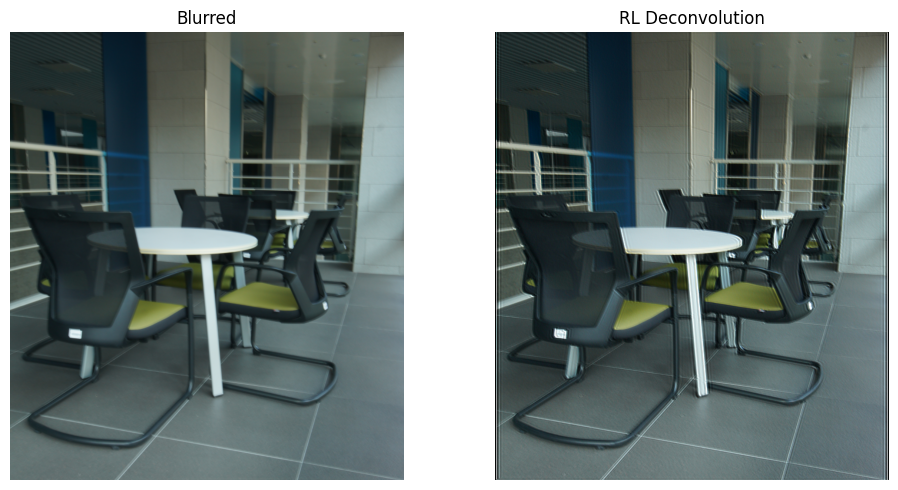

In [5]:
import random
import matplotlib.pyplot as plt

if len(img_files) > 0:
    sample_path = random.choice(img_files)
    orig = img_as_float(io.imread(sample_path))
    rl   = img_as_float(io.imread(os.path.join(OUTPUT_DIR, os.path.basename(sample_path))))

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(orig)
    axs[0].set_title("Blurred")
    axs[0].axis("off")

    axs[1].imshow(rl)
    axs[1].set_title("RL Deconvolution")
    axs[1].axis("off")

    plt.tight_layout()
    plt.show()

Total usable images: 5
Selected files: ['scene006-13.png', 'scene006-14.png', 'scene006-10.png', 'scene006-11.png']


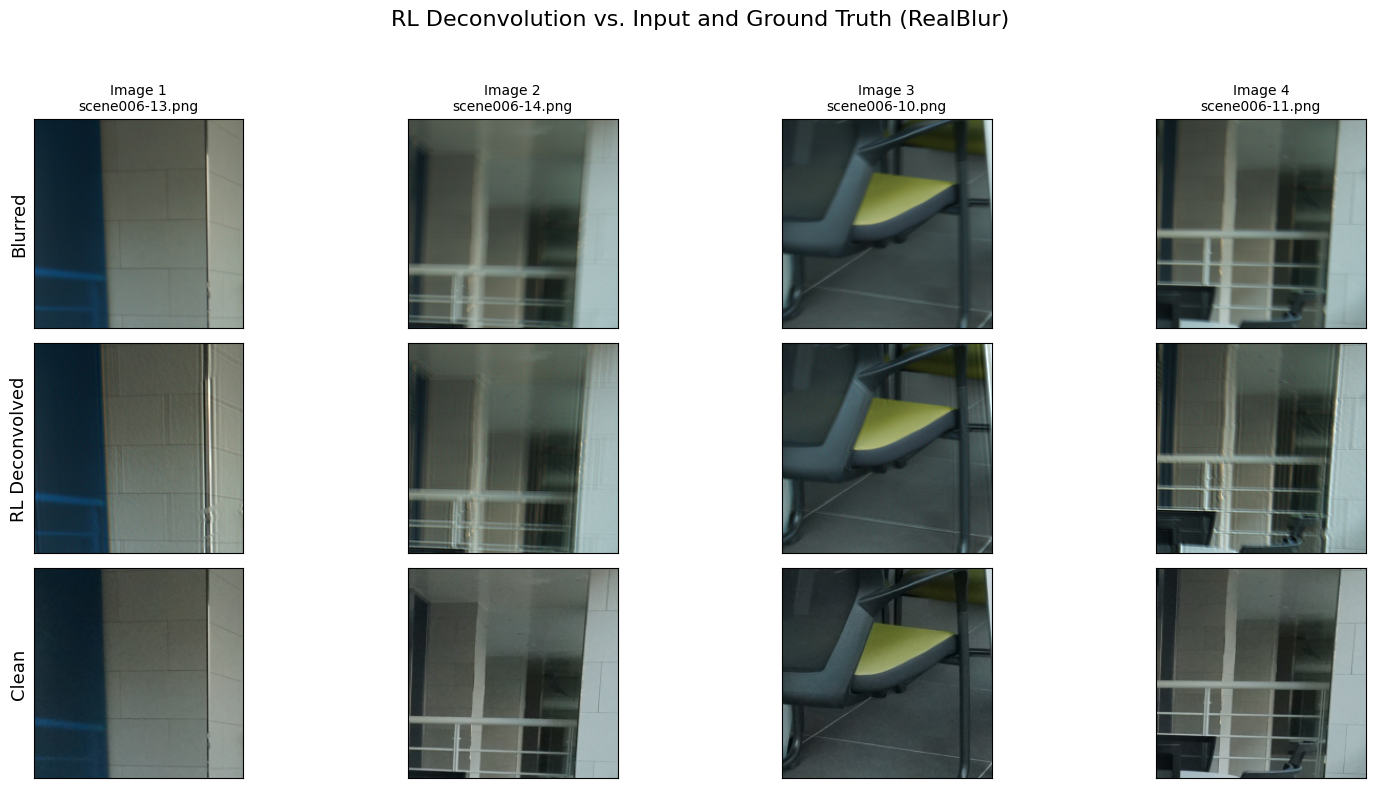

In [7]:
import os
import random
import matplotlib.pyplot as plt
import numpy as np
from skimage import io, img_as_float

# -----------------------------
# Paths (RealBlur example)
# -----------------------------
blur_dir  = "./MPRNet-main/Deblurring/Datasets/RealBlur/test/input"
clean_dir = "./MPRNet-main/Deblurring/Datasets/RealBlur/test/target"
rl_dir    = "./DeblurResult/RealBlur_RL/output"

IMG_EXTS = (".png", ".jpg", ".jpeg")

# -----------------------------
# Controls
# -----------------------------
NUM_SHOW   = 4      # exactly 4 images in one figure
CROP_SIZE  = 200    # set None to disable cropping
RANDOM_SEED_FILES = 0
RANDOM_SEED_CROP  = 123

# -----------------------------
# Image loading helper
# -----------------------------
def load_img(path):
    img = io.imread(path)
    if img.ndim == 2:
        img = np.stack([img, img, img], axis=-1)
    return img_as_float(img)

# -----------------------------
# Collect common files
# -----------------------------
all_blur_files = [f for f in os.listdir(blur_dir) if f.lower().endswith(IMG_EXTS)]

common_files = []
for f in all_blur_files:
    if (os.path.exists(os.path.join(clean_dir, f)) and
        os.path.exists(os.path.join(rl_dir, f))):
        common_files.append(f)

common_files = sorted(common_files)
print("Total usable images:", len(common_files))

if len(common_files) == 0:
    raise RuntimeError("No common images found in blur/clean/RL directories.")

# -----------------------------
# Select exactly 4 files
# -----------------------------
random.seed(RANDOM_SEED_FILES)
num_show = min(NUM_SHOW, len(common_files))
selected = random.sample(common_files, num_show)
print("Selected files:", selected)

# -----------------------------
# Plot grid: 3 rows x 4 columns in ONE figure
# Each column is one selected image
# Rows: Blurred / RL / Clean
# Optional: fixed random crop per column
# -----------------------------
def plot_rl_comparison_grid(selected_files, crop_size=200, crop_seed=123, title="RL Deconvolution (RealBlur)"):
    n = len(selected_files)
    fig, axes = plt.subplots(3, n, figsize=(4 * n, 8))
    axes = np.atleast_2d(axes)

    row_titles = ["Blurred", "RL Deconvolved", "Clean"]
    rng = random.Random(crop_seed)

    for col, fname in enumerate(selected_files):
        blur  = load_img(os.path.join(blur_dir,  fname))
        rl    = load_img(os.path.join(rl_dir,    fname))
        clean = load_img(os.path.join(clean_dir, fname))

        # Ensure same spatial size (if needed)
        H = min(blur.shape[0], rl.shape[0], clean.shape[0])
        W = min(blur.shape[1], rl.shape[1], clean.shape[1])
        blur  = blur[:H, :W, :]
        rl    = rl[:H, :W, :]
        clean = clean[:H, :W, :]

        # Optional crop (same crop for the 3 images in this column)
        if crop_size is not None:
            cs = min(crop_size, H, W)
            y0 = 0 if H == cs else rng.randint(0, H - cs)
            x0 = 0 if W == cs else rng.randint(0, W - cs)
            blur  = blur[y0:y0+cs, x0:x0+cs, :]
            rl    = rl[y0:y0+cs, x0:x0+cs, :]
            clean = clean[y0:y0+cs, x0:x0+cs, :]

        imgs = [blur, rl, clean]

        for row in range(3):
            ax = axes[row, col]
            ax.imshow(imgs[row])
            ax.set_xticks([])
            ax.set_yticks([])

            if col == 0:
                ax.set_ylabel(row_titles[row], fontsize=13)

            if row == 0:
                ax.set_title(f"Image {col+1}\n{fname}", fontsize=10)

    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

plot_rl_comparison_grid(
    selected_files=selected,
    crop_size=CROP_SIZE,
    crop_seed=RANDOM_SEED_CROP,
    title="RL Deconvolution vs. Input and Ground Truth (RealBlur)"
)